In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import torch
from einops import rearrange, reduce, asnumpy
from scipy import stats as sstats
import tqdm 
from tqdm import trange

from vgiwae.models import VAEMargLogprob, IWAEMargLogprob
from vgiwae.models import MultipleVAEMargLogprob, MultipleIWAEMargLogprob
from vgiwae.shared.vae_marginal_logprob import create_2D_grid, create_Z, get_marginal_logprob_for_Zgrid
from vgiwae.data.missing_data_module import *
from vgiwae.shared.stratified_mixture_same_family import StratifiedMixtureSameFamily
from vgiwae.shared.vae_enums import DISTRIBUTION
from vgiwae.shared.iwae import compute_smis_log_unnormalised_importance_weights

from vgiwae.data.toy import plot_data_pairwise

In [2]:
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath} \usepackage{amsfonts}"

plt.style.use('seaborn-colorblind')

## Helpers

In [3]:
def create_grid(min_v, max_v, bins=100):
    """Creates the grid for visualising 2D marginal densities"""
    x0, x1 = np.mgrid[min_v:max_v*1.01:(max_v-min_v)/bins, 
                      min_v:max_v*1.01:(max_v-min_v)/bins]
    pos = np.empty(x0.shape + (2,))
    pos[:, :, 0] = x0
    pos[:, :, 1] = x1
    return x0, x1, torch.tensor(pos).float()

def create_mv_mog(comp_logits, means, *, covs=None, scale_trils=None):
    mix = torch.distributions.Categorical(logits=comp_logits)
    multi_norms = torch.distributions.MultivariateNormal(
        loc=means, covariance_matrix=covs, scale_tril=scale_trils)
    comp = torch.distributions.Independent(multi_norms, 0)
    mog = torch.distributions.MixtureSameFamily(mix, comp)

    return mog

def create_univariate_mog(comp_logits, means, variances):
    mix = torch.distributions.Categorical(logits=comp_logits)
    norms = torch.distributions.Normal(
        loc=means, scale=variances**0.5)
    mog = torch.distributions.MixtureSameFamily(mix, norms)
    return mog
    

def marginal_log_prob_mog(X, params, dims):
    """Marginal log-probability of the chosen dimensions evaluated at X"""
    comp_logits = params['comp_logits']
    means = params['means'][:, dims]
    covs = params['covs'][:, dims, :][:, :, dims]
    
    mog = create_mv_mog(comp_logits, means, covs=covs)
    
    return mog.log_prob(X)

def univariate_log_prob_mog(X, params, dim):
    comp_logits = params['comp_logits']
    means = params['means'][:, dim]
    var = params['covs'][:, :, dim][:, dim]
    
    mog = create_univariate_mog(comp_logits, means, var)
    
    return mog.log_prob(X)

def plot_pairwise_marginal_contourfs(fig, grid_spec, dims, limits, params, *, 
                                     bins=100, data=None, log_domain=False, 
                                     rasterize_contours=False, scatter_color='b',
                                    label_fontsize=14):
    """Used for plotting pairwise 2D marginals as filled contour plots"""
    min_v, max_v = limits
    
    artists = []
    for i in range(0, dims):
        for j in range(i+1, dims):
            # Plot pairs of dimensions
            ax = fig.add_subplot(grid_spec[i, j-1])
            artists.append(ax)

            x0, x1, pos = create_grid(min_v, max_v, bins=bins)

            log_pdf = marginal_log_prob_mog(pos, params, dims=[i, j])
            pdf = torch.exp(log_pdf)

            contour = ax.contourf(x1, x0, log_pdf if log_domain else pdf, levels=10)
            
            if rasterize_contours:
                for c in contour.collections:
                    c.set_rasterized(True)
            
            if data is not None:
                ax.scatter(data[:, j], data[:, i], alpha=0.4, marker='.', color=scatter_color)

            ax.tick_params(left=False, labelleft=False,
                           bottom=False, labelbottom=False)

            # Set common limits
            ax.set_ylim(min_v, max_v)
            ax.set_xlim(min_v, max_v)

            if i == 0:
                ax.set_title(f'dim={j}', fontsize=label_fontsize)
            if j == 1:
                ax.set_ylabel(f'dim={i}', fontsize=label_fontsize)

        # Create dummy axes to add labels on the left-hand side
        if 0 < i < (dims-1):
            ax = fig.add_subplot(dims-1, dims-1, i*(dims-1)+1)
            artists.append(ax)
            ax.set_ylabel(f'dim={i}', fontsize=label_fontsize)
            # Hide the dummy axes
            ax.xaxis.set_visible(False)
            plt.setp(ax.spines.values(), visible=False)
            ax.tick_params(left=False, labelleft=False)
            ax.patch.set_visible(False)

    grid_spec.tight_layout(fig)
    
    return artists

In [4]:
def compute_complete_variational_posterior_grid_logprob(vae, X, Z):
    var_params = vae.predict_var_latent_params(X, torch.ones_like(X))
    var_distr = vae.create_distribution(var_params, vae.hparams.var_latent_distribution)
    Z = rearrange(Z, 'z d -> z 1 d')
    return var_distr.log_prob(Z).sum(dim=-1)

def compute_incomplete_variational_posterior_grid_logprob(vae, X, M, Z):
    var_params = vae.predict_var_latent_params(X*M, M)
    var_distr = vae.create_distribution(var_params, vae.hparams.var_latent_distribution)
    Z = rearrange(Z, 'z d -> z 1 d')
    log_prob = var_distr.log_prob(Z)
    if not isinstance(var_distr, StratifiedMixtureSameFamily):
        log_prob = log_prob.sum(dim=-1)
        
    return log_prob

def compute_iwae_posterior_grid_logprob_using_kde(vae, X, M, Z, *, 
                                                  num_importance_samples, num_indep_samples):
    var_params = vae.predict_var_latent_params(X*M, M)
    var_distr = vae.create_distribution(var_params, vae.hparams.var_latent_distribution)
    
    sample_stratifieddistr_without_stratification_norsample = False
    if isinstance(var_distr, StratifiedMixtureSameFamily):
        sample_stratifieddistr_without_stratification_norsample=True
    
    vae_forward_outputs = vae.vae_forward(X*M, M, return_detached_latent_distr=True, 
                                  Z_sample_shape=(num_indep_samples, num_importance_samples, ), 
                                  sample_stratifieddistr_without_stratification_norsample=sample_stratifieddistr_without_stratification_norsample)
    var_latent_distr = vae_forward_outputs.var_latent_distr
    var_latent_distr_detached = vae_forward_outputs.var_latent_distr_detached
    Z_var = vae_forward_outputs.Z
    prior_distr = vae_forward_outputs.prior_distr
    generator_distr = vae_forward_outputs.generator_distr
        
    log_weights = compute_smis_log_unnormalised_importance_weights(X, M, Z_var,
                                                                   var_latent_distr_detached,
                                                                   prior_distr,
                                                                   generator_distr)
    
    log_weights = rearrange(log_weights, 'z i b -> z b i')
    
    cat = torch.distributions.categorical.Categorical(probs=None, logits=log_weights, validate_args=None)
    idx = cat.sample()
    Z_var = rearrange(Z_var, 'z i b d -> z b i d')
    
    Z_var = Z_var[torch.arange(num_indep_samples).unsqueeze(1), torch.arange(X.shape[0]).unsqueeze(0), idx, :]
    log_prob = []
    for b in trange(X.shape[0]):
        kde = sstats.gaussian_kde(asnumpy(rearrange(Z_var[:, b, :], 'z d -> d z')))
        log_prob.append(kde.logpdf(asnumpy(rearrange(Z, 'z d -> d z'))))
        
    log_prob = np.stack(log_prob, axis=-1)
    log_prob = torch.tensor(log_prob)
    
    return log_prob
    
    
    
def compute_mixture_variational_logprob(vae, X, M, Z, *, 
                                        num_mixtures, max_joint_logprob_pxoz, grid_min, grid_max,
                                        Z_batch_size=3000):
    Z = rearrange(Z, 'z d -> z 1 1 d')
    
    # Sample posterior p(z | xo)
    Z_post = sample_pz_given_xo_with_rejection_sampling(vae, X, M,
                                                        num_samples=num_mixtures,
                                                        joint_logprob_max=max_joint_logprob_pxoz,
                                                        Z_batchsize=Z_batch_size,
                                                        Z_min=grid_min,
                                                        Z_max=grid_max)
    
    variational_logprob = []
    for b in range(0, num_mixtures, Z_batch_size):
        Z_post_b = Z_post[:, b:min(b+Z_batch_size,num_mixtures), :]
        
        # Compute the parameters of the generator
        generator_params = vae.generator_network(Z_post_b)
        # Compute the conditional log-likelihood of each data-point
        generator_distr = vae.create_distribution(generator_params, vae.hparams.generator_distribution)

        # Sample imputations p(xm | xo)
        X_imps = generator_distr.sample()
        X_imputed = rearrange(X, 'b d -> b 1 d')*rearrange(M, 'b d -> b 1 d') + X_imps*rearrange(~M, 'b d -> b 1 d')

        # Computed q for each imputation
        var_params = vae.predict_var_latent_params(X_imputed, torch.ones_like(X)) # (b k d)
        var_distr = vae.create_distribution(var_params, vae.hparams.var_latent_distribution)
        
        variational_logprob_b = var_distr.log_prob(Z).sum(dim=-1)
        variational_logprob.append(variational_logprob_b)
    variational_logprob = torch.cat(variational_logprob, dim=-1)
        
    variational_logprob = torch.logsumexp(variational_logprob, dim=-1) - torch.log(torch.tensor(variational_logprob.shape[-1]))
    return variational_logprob

def sample_pz_given_xo_with_rejection_sampling(vae, X, M, num_samples, joint_logprob_max, Z_batchsize, Z_min, Z_max):
    samples = torch.empty(joint_logprob_max.shape[0], num_samples, 2)
    for i in range(len(joint_logprob_max)):
        found_samples = 0
        while found_samples < num_samples:
            Z = torch.rand(Z_batchsize, 2)*(Z_max-Z_min) + Z_min

            # Compute prior logprob
            prior_dist = torch.distributions.Normal(loc=0, scale=1.)
            prior_logprob = prior_dist.log_prob(Z)
            prior_logprob = reduce(prior_logprob, 'z d -> z', 'sum')

            # Compute the parameters of the generator
            generator_params = vae.generator_network(Z)
            generator_params = rearrange(generator_params, 'z pd -> z pd')
            # Compute the conditional log-likelihood of each data-point
            generator_distr = vae.create_distribution(generator_params, vae.hparams.generator_distribution)
            comp_cond_logprob = generator_distr.log_prob(X[i])
            cond_logprob = comp_cond_logprob*M[i]
            cond_logprob = cond_logprob.sum(dim=-1)

            # Compute the joint
            joint_logprob = prior_logprob + cond_logprob
            joint_prob = torch.exp(joint_logprob)

            # Rejection sampling
            u = torch.rand(Z_batchsize)*torch.exp(joint_logprob_max[i])
            accepted = (u < joint_prob)

            # 
            Z_accepted = Z[accepted]
#             print('Accepted:', Z_accepted.shape)
            num_accepted_samples = Z_accepted.shape[0]

            samples[i, found_samples:min(found_samples+num_accepted_samples, num_samples)] = \
                Z_accepted[:num_samples-found_samples]
            found_samples += num_accepted_samples
    return samples

In [5]:
def sample_vae(vae, num_samples):
    with torch.inference_mode():
        generator_params = vae.generator_network(torch.randn(num_samples, 2))
        generator_distr = vae.create_distribution(generator_params, vae.hparams.generator_distribution)
        samples = generator_distr.sample()
    return samples

In [6]:
def plot_2d_vae_post(posterior_logprob, z0, z1, ax=None, plot_log=False, *, colors=None):
    # Compute posterior logprob
    if plot_log:
        posterior_plot = posterior_logprob
    else:
        posterior_plot = torch.exp(posterior_logprob)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(9,9))

    posterior_plot = rearrange(posterior_plot, '(z0 z1) b -> z0 z1 b', z0=z0.shape[0])
    posterior_plot = asnumpy(posterior_plot)

    if colors is None:
        cmap = mpl.cm.get_cmap('gist_ncar')
        colors = cmap(np.linspace(0, 0.95, posterior_plot.shape[2]))
    for p in range(posterior_plot.shape[2]):
        ct = ax.contour(z0, z1, posterior_plot[:, :, p], levels=3, colors=mpl.colors.to_hex(colors[p], keep_alpha=False))
        # Remove first contour
        ct.collections[0].remove()

    ax.grid()

## Toy mog 2

In [7]:
datamodule = MissingDataModule(DATASET['toy_mog2'],
                         batch_size=200,
                         missingness=MISSINGNESS['uniform'], # TODO: load by subclass instead?
                         total_miss_train=0.5,         # TODO: load by subclass instead?
                         total_miss_val=0.5,         # TODO: load by subclass instead?
                         pre_imputation=PRE_IMPUTATION['oracle'],
                         pre_impute_val=True,
                         filter_fully_missing_train=True,
                         filter_fully_missing_val=True,
                         data_root="../data",
                         setup_seed=20220118)
datamodule.setup(stage='fit')

X, M = datamodule.val_data[:20][:2]
X, M = torch.tensor(X), torch.tensor(M)

Train data size: 871
Validation data size: 97


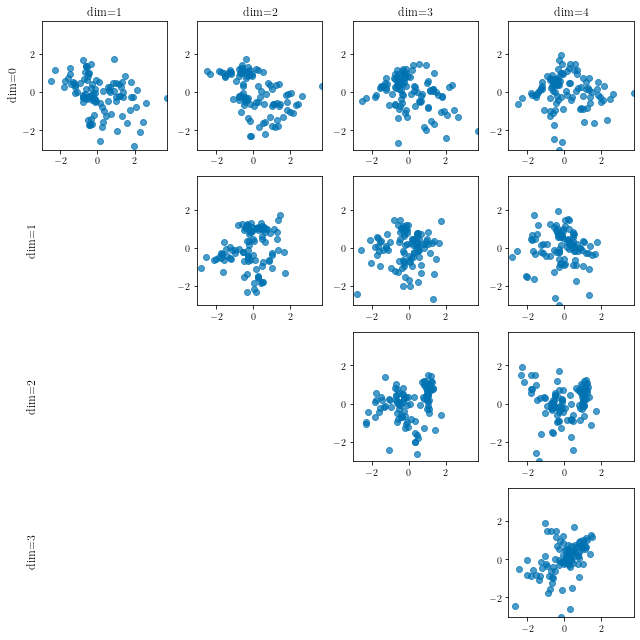

In [8]:
version = '1423096'
checkpoint = 'epoch=499-step=7499'
vae = VAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2/compare/complete_vae_stl_mlp/mis00/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')
samples = sample_vae(vae, 100)
fig = plot_data_pairwise(samples)

Train data size: 19366
Validation data size: 98


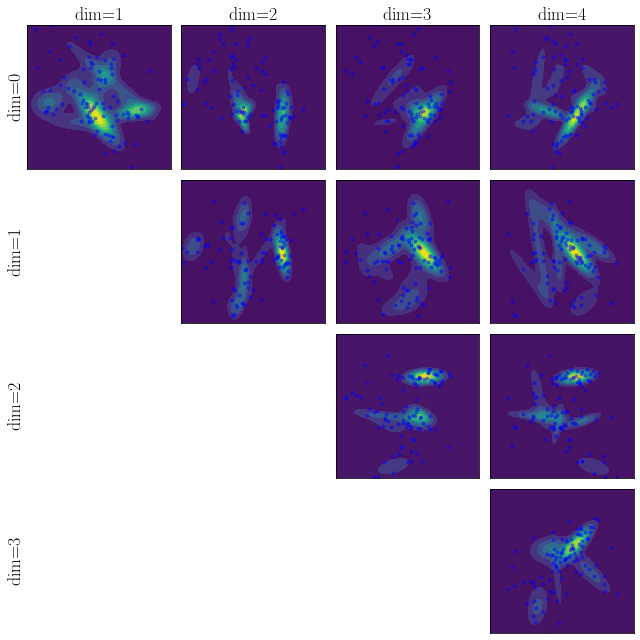

In [9]:
datamodule_large = MissingDataModule(DATASET['toy_mog2_large'],
                         batch_size=200,
                         missingness=MISSINGNESS['uniform'], # TODO: load by subclass instead?
                         total_miss_train=0.5,         # TODO: load by subclass instead?
                         total_miss_val=0.5,         # TODO: load by subclass instead?
                         pre_imputation=PRE_IMPUTATION['oracle'],
                         pre_impute_val=True,
                         filter_fully_missing_train=True,
                         filter_fully_missing_val=True,
                         data_root="../data",
                         setup_seed=20220118)
datamodule_large.setup(stage='fit')

dims = datamodule_large.train_data_core.data_file['means'].shape[-1]

fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(ncols=dims-1, nrows=dims-1, figure=fig)

# max_v = data[:].max()*0.15
min_v = np.quantile(datamodule_large.train_data_core.data[:], 0.01)
# min_v = data[:].min()*0.15
max_v = np.quantile(datamodule_large.train_data_core.data[:], 0.99)


params = {
    'comp_logits': torch.tensor(np.log(datamodule_large.train_data_core.data_file['comp_probs'])),
    'covs': torch.tensor(datamodule_large.train_data_core.data_file['covs']),
    'means': torch.tensor(datamodule_large.train_data_core.data_file['means'])
}

artists = plot_pairwise_marginal_contourfs(fig, gs, dims, (min_v, max_v), params, 
                                 rasterize_contours=True,
                                 bins=1000, 
#                                  data=datamodule_large.train_data_core.data[:100]
                                           data=samples,
                                   label_fontsize=18
                                          )

# fig.savefig('figures/mog_marginals.pdf')

## Create a figure

Sum: tensor(1.0000)
Sum: tensor(1.0000)
Sum: tensor(0.9975)
Sum: tensor(0.9633)


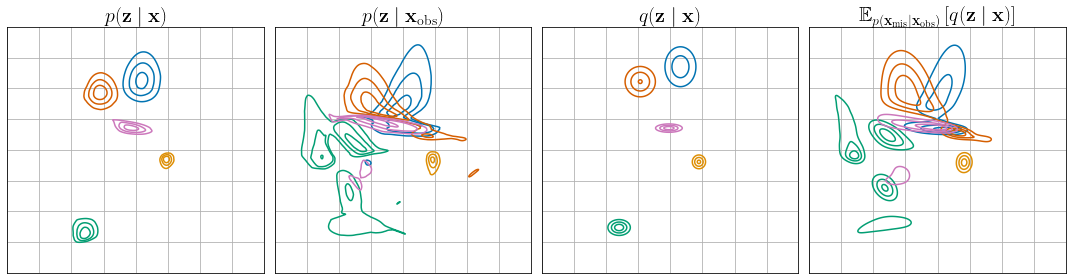

In [10]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15, 4))
axes = axes.flatten()

# X_temp, M_temp = datamodule.val_data[:20][:2]
X_temp, M_temp = datamodule.train_data[40:45][:2]
X_temp, M_temp = torch.tensor(X_temp), torch.tensor(M_temp)

# Load model
version = '1423096'
checkpoint = 'epoch=499-step=7499'
cvae = VAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2/compare/complete_vae_stl_mlp/mis00/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')

# Create grid
grid_min, grid_max = -2, 2
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# Compute marginal and joint
with torch.inference_mode():
    out = get_marginal_logprob_for_Zgrid(cvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                         compute_complete=True, return_joint=True, 
                                         marginal_eval_batchsize=1)

# Complete data
posterior_logprob = out['complete_joint_logprob_pxz'] - out['complete_marginal_logprob_px']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[0], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Incomplete data
posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[1], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Complete variational
with torch.inference_mode():
    variational_logprob = compute_complete_variational_posterior_grid_logprob(vae, X_temp, Z)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[2], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

# Incomplete variational mixture
with torch.inference_mode():
    variational_logprob = compute_mixture_variational_logprob(cvae, X_temp, M_temp, Z,
                                                              num_mixtures=10000, 
                                                              max_joint_logprob_pxoz=out['joint_logprob_pxoz'].max(dim=0)[0], 
                                                              grid_min=grid_min, 
                                                              grid_max=grid_max,
                                                             Z_batch_size=1500)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[3], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

fontsize=20

axes[0].set_title('$p(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=fontsize)
axes[1].set_title('$p(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=fontsize)
axes[2].set_title('$q(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=fontsize)
axes[3].set_title('$\\mathbb{E}_{p(\\mathbf{x}_{\\text{mis}} \\mid \\mathbf{x}_{\\text{obs}})}\\left[q(\\mathbf{z} \\mid \\mathbf{x})\\right]$', fontsize=fontsize)

axes[0].set_yticklabels([])
for i in range(len(axes)):
    axes[i].set_xticklabels([])
    for tic in axes[i].xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
    for tic in axes[i].yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
    
# Plot scatters
# Z_post = sample_pz_given_xo_with_rejection_sampling(vae, X_temp, torch.ones_like(M_temp),
#                                            num_samples=500,
#                                            joint_logprob_max=out['complete_joint_logprob_pxz'].max(dim=0)[0],
#                                            Z_batchsize=10000,
#                                            Z_min=grid_min,
#                                            Z_max=grid_max)

# for z in range(Z_post.shape[0]):
#     axes[0].scatter(Z_post[z, :, 0], Z_post[z, :, 1], color=colors[z], alpha=0.3)

# Z_post = sample_pz_given_xo_with_rejection_sampling(vae, X_temp, M_temp,
#                                            num_samples=500,
#                                            joint_logprob_max=out['joint_logprob_pxoz'].max(dim=0)[0],
#                                            Z_batchsize=10000,
#                                            Z_min=grid_min,
#                                            Z_max=grid_max)

# for z in range(Z_post.shape[0]):
#     axes[1].scatter(Z_post[z, :, 0], Z_post[z, :, 1], color=colors[z], alpha=0.3)

fig.tight_layout()

# fig.savefig('figures/toy_mog2-complete-posteriors.pdf', bbox_inches='tight')

### Poster figure

Sum: tensor(1.0000)
Sum: tensor(1.0000)


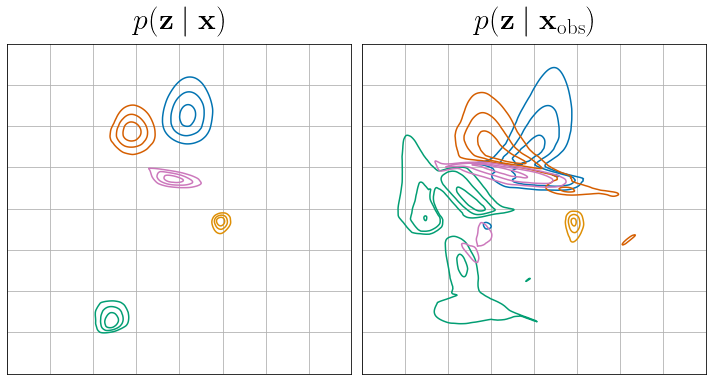

In [21]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5.4))
axes = axes.flatten()

# X_temp, M_temp = datamodule.val_data[:20][:2]
X_temp, M_temp = datamodule.train_data[40:45][:2]
X_temp, M_temp = torch.tensor(X_temp), torch.tensor(M_temp)

# Load model
version = '1423096'
checkpoint = 'epoch=499-step=7499'
cvae = VAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2/compare/complete_vae_stl_mlp/mis00/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')

# Create grid
grid_min, grid_max = -2, 2
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# Compute marginal and joint
with torch.inference_mode():
    out = get_marginal_logprob_for_Zgrid(cvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                         compute_complete=True, return_joint=True, 
                                         marginal_eval_batchsize=1)

# Complete data
posterior_logprob = out['complete_joint_logprob_pxz'] - out['complete_marginal_logprob_px']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[0], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Incomplete data
posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[1], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# # Complete variational
# with torch.inference_mode():
#     variational_logprob = compute_complete_variational_posterior_grid_logprob(vae, X_temp, Z)
# plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[2], colors=colors)
# print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

# # Incomplete variational mixture
# with torch.inference_mode():
#     variational_logprob = compute_mixture_variational_logprob(cvae, X_temp, M_temp, Z,
#                                                               num_mixtures=10000, 
#                                                               max_joint_logprob_pxoz=out['joint_logprob_pxoz'].max(dim=0)[0], 
#                                                               grid_min=grid_min, 
#                                                               grid_max=grid_max,
#                                                              Z_batch_size=1500)
# plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[3], colors=colors)
# print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

fontsize=30
title_pad=15

axes[0].set_title('$p(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=fontsize, pad=15)
axes[1].set_title('$p(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=fontsize, pad=15)
# axes[2].set_title('$q(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=fontsize, pad=15)
# axes[3].set_title('$\\mathbb{E}_{p(\\mathbf{x}_{\\text{mis}} \\mid \\mathbf{x}_{\\text{obs}})}\\left[q(\\mathbf{z} \\mid \\mathbf{x})\\right]$', fontsize=fontsize, pad=15)

axes[0].set_yticklabels([])
for i in range(len(axes)):
    axes[i].set_xticklabels([])
    for tic in axes[i].xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
    for tic in axes[i].yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
    
# Plot scatters
# Z_post = sample_pz_given_xo_with_rejection_sampling(vae, X_temp, torch.ones_like(M_temp),
#                                            num_samples=500,
#                                            joint_logprob_max=out['complete_joint_logprob_pxz'].max(dim=0)[0],
#                                            Z_batchsize=10000,
#                                            Z_min=grid_min,
#                                            Z_max=grid_max)

# for z in range(Z_post.shape[0]):
#     axes[0].scatter(Z_post[z, :, 0], Z_post[z, :, 1], color=colors[z], alpha=0.3)

# Z_post = sample_pz_given_xo_with_rejection_sampling(vae, X_temp, M_temp,
#                                            num_samples=500,
#                                            joint_logprob_max=out['joint_logprob_pxoz'].max(dim=0)[0],
#                                            Z_batchsize=10000,
#                                            Z_min=grid_min,
#                                            Z_max=grid_max)

# for z in range(Z_post.shape[0]):
#     axes[1].scatter(Z_post[z, :, 0], Z_post[z, :, 1], color=colors[z], alpha=0.3)

fig.tight_layout()

fig.savefig('figures/toy_mog2-complete-posteriors_poster_model.pdf', bbox_inches='tight')

Sum: tensor(0.9975)
Sum: tensor(0.9624)


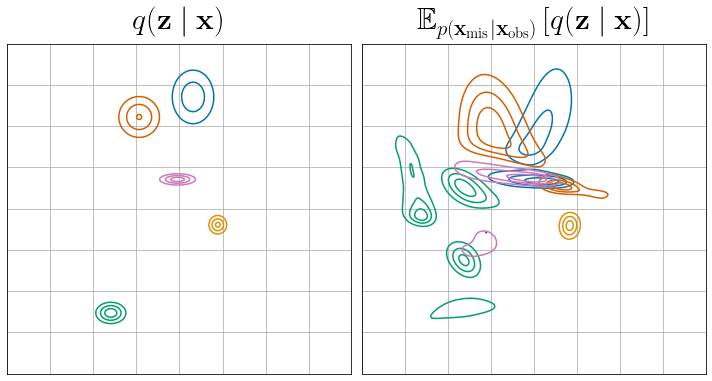

In [22]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5.4))
axes = axes.flatten()

# X_temp, M_temp = datamodule.val_data[:20][:2]
X_temp, M_temp = datamodule.train_data[40:45][:2]
X_temp, M_temp = torch.tensor(X_temp), torch.tensor(M_temp)

# Load model
version = '1423096'
checkpoint = 'epoch=499-step=7499'
cvae = VAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2/compare/complete_vae_stl_mlp/mis00/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')

# Create grid
grid_min, grid_max = -2, 2
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# # Compute marginal and joint
# with torch.inference_mode():
#     out = get_marginal_logprob_for_Zgrid(cvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
#                                          compute_complete=True, return_joint=True, 
#                                          marginal_eval_batchsize=1)

# # Complete data
# posterior_logprob = out['complete_joint_logprob_pxz'] - out['complete_marginal_logprob_px']
# plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[0], colors=colors)
# print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# # Incomplete data
# posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
# plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[1], colors=colors)
# print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Complete variational
with torch.inference_mode():
    variational_logprob = compute_complete_variational_posterior_grid_logprob(vae, X_temp, Z)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[0], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

# Incomplete variational mixture
with torch.inference_mode():
    variational_logprob = compute_mixture_variational_logprob(cvae, X_temp, M_temp, Z,
                                                              num_mixtures=10000, 
                                                              max_joint_logprob_pxoz=out['joint_logprob_pxoz'].max(dim=0)[0], 
                                                              grid_min=grid_min, 
                                                              grid_max=grid_max,
                                                             Z_batch_size=1500)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[1], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

fontsize=30
title_pad=15

# axes[0].set_title('$p(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=fontsize, pad=15)
# axes[1].set_title('$p(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=fontsize, pad=15)
axes[0].set_title('$q(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=fontsize, pad=15)
axes[1].set_title('$\\mathbb{E}_{p(\\mathbf{x}_{\\text{mis}} \\mid \\mathbf{x}_{\\text{obs}})}\\left[q(\\mathbf{z} \\mid \\mathbf{x})\\right]$', fontsize=fontsize, pad=15)

axes[0].set_yticklabels([])
for i in range(len(axes)):
    axes[i].set_xticklabels([])
    for tic in axes[i].xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
    for tic in axes[i].yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
    
# Plot scatters
# Z_post = sample_pz_given_xo_with_rejection_sampling(vae, X_temp, torch.ones_like(M_temp),
#                                            num_samples=500,
#                                            joint_logprob_max=out['complete_joint_logprob_pxz'].max(dim=0)[0],
#                                            Z_batchsize=10000,
#                                            Z_min=grid_min,
#                                            Z_max=grid_max)

# for z in range(Z_post.shape[0]):
#     axes[0].scatter(Z_post[z, :, 0], Z_post[z, :, 1], color=colors[z], alpha=0.3)

# Z_post = sample_pz_given_xo_with_rejection_sampling(vae, X_temp, M_temp,
#                                            num_samples=500,
#                                            joint_logprob_max=out['joint_logprob_pxoz'].max(dim=0)[0],
#                                            Z_batchsize=10000,
#                                            Z_min=grid_min,
#                                            Z_max=grid_max)

# for z in range(Z_post.shape[0]):
#     axes[1].scatter(Z_post[z, :, 0], Z_post[z, :, 1], color=colors[z], alpha=0.3)

fig.tight_layout()

fig.savefig('figures/toy_mog2-complete-posteriors_poster_variational.pdf', bbox_inches='tight')

### Website thumbnail

Sum: tensor(1.0000)
Sum: tensor(0.9975)


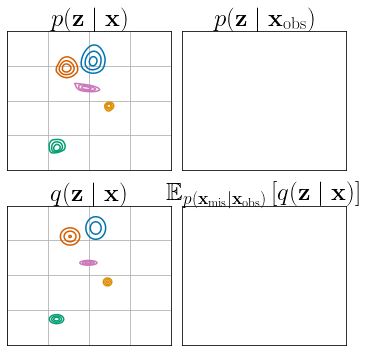

In [35]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.flatten()

# X_temp, M_temp = datamodule.val_data[:20][:2]
X_temp, M_temp = datamodule.train_data[40:45][:2]
X_temp, M_temp = torch.tensor(X_temp), torch.tensor(M_temp)

# Load model
version = '1423096'
checkpoint = 'epoch=499-step=7499'
cvae = VAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2/compare/complete_vae_stl_mlp/mis00/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')

# Create grid
grid_min, grid_max = -2, 2
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# Compute marginal and joint
with torch.inference_mode():
    out = get_marginal_logprob_for_Zgrid(cvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                         compute_complete=True, return_joint=True, 
                                         marginal_eval_batchsize=1)

# Complete data
posterior_logprob = out['complete_joint_logprob_pxz'] - out['complete_marginal_logprob_px']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[0], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# # Incomplete data
# posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
# plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[1], colors=colors)
# print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Complete variational
with torch.inference_mode():
    variational_logprob = compute_complete_variational_posterior_grid_logprob(vae, X_temp, Z)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[2], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

# # Incomplete variational mixture
# with torch.inference_mode():
#     variational_logprob = compute_mixture_variational_logprob(cvae, X_temp, M_temp, Z,
#                                                               num_mixtures=10000, 
#                                                               max_joint_logprob_pxoz=out['joint_logprob_pxoz'].max(dim=0)[0], 
#                                                               grid_min=grid_min, 
#                                                               grid_max=grid_max,
#                                                              Z_batch_size=1500)
# plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[3], colors=colors)
# print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

fontsize=25

axes[0].set_title('$p(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=fontsize)
axes[1].set_title('$p(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=fontsize)
axes[2].set_title('$q(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=fontsize)
axes[3].set_title('$\\mathbb{E}_{p(\\mathbf{x}_{\\text{mis}} \\mid \\mathbf{x}_{\\text{obs}})}\\left[q(\\mathbf{z} \\mid \\mathbf{x})\\right]$', fontsize=fontsize)

axes[0].set_yticklabels([])
for i in range(len(axes)):
    axes[i].set_xticklabels([])
    for tic in axes[i].xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
    for tic in axes[i].yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)

fig.tight_layout()
# axes[1].axis('off')
# axes[3].axis('off')
# axes[1].title.set_visible(False)
# axes[3].title.set_visible(False)

# fig.tight_layout()

fig.savefig('figures/toy_mog2-complete-posteriors-thumbnail-default.png', bbox_inches='tight')

Sum: tensor(1.0000)
Sum: tensor(1.0000)
Sum: tensor(0.9975)
Sum: tensor(0.9624)


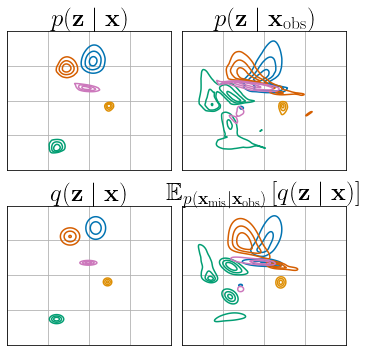

In [22]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.flatten()

# X_temp, M_temp = datamodule.val_data[:20][:2]
X_temp, M_temp = datamodule.train_data[40:45][:2]
X_temp, M_temp = torch.tensor(X_temp), torch.tensor(M_temp)

# Load model
version = '1423096'
checkpoint = 'epoch=499-step=7499'
cvae = VAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2/compare/complete_vae_stl_mlp/mis00/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')

# Create grid
grid_min, grid_max = -2, 2
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# Compute marginal and joint
with torch.inference_mode():
    out = get_marginal_logprob_for_Zgrid(cvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                         compute_complete=True, return_joint=True, 
                                         marginal_eval_batchsize=1)

# Complete data
posterior_logprob = out['complete_joint_logprob_pxz'] - out['complete_marginal_logprob_px']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[0], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Incomplete data
posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[1], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Complete variational
with torch.inference_mode():
    variational_logprob = compute_complete_variational_posterior_grid_logprob(vae, X_temp, Z)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[2], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

# Incomplete variational mixture
with torch.inference_mode():
    variational_logprob = compute_mixture_variational_logprob(cvae, X_temp, M_temp, Z,
                                                              num_mixtures=10000, 
                                                              max_joint_logprob_pxoz=out['joint_logprob_pxoz'].max(dim=0)[0], 
                                                              grid_min=grid_min, 
                                                              grid_max=grid_max,
                                                             Z_batch_size=1500)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[3], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

fontsize=25

axes[0].set_title('$p(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=fontsize)
axes[1].set_title('$p(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=fontsize)
axes[2].set_title('$q(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=fontsize)
axes[3].set_title('$\\mathbb{E}_{p(\\mathbf{x}_{\\text{mis}} \\mid \\mathbf{x}_{\\text{obs}})}\\left[q(\\mathbf{z} \\mid \\mathbf{x})\\right]$', fontsize=fontsize)

axes[0].set_yticklabels([])
for i in range(len(axes)):
    axes[i].set_xticklabels([])
    for tic in axes[i].xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
    for tic in axes[i].yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)

fig.tight_layout()

# fig.savefig('figures/toy_mog2-complete-posteriors-thumbnail-on-hover.png', bbox_inches='tight')

## Mixture-VAE and Mixture-IWAE plots 

In [7]:
large_datamodule = MissingDataModule(DATASET['toy_mog2_large'],
                         batch_size=200,
                         missingness=MISSINGNESS['uniform'], # TODO: load by subclass instead?
                         total_miss_train=0.5,         # TODO: load by subclass instead?
                         total_miss_val=0.5,         # TODO: load by subclass instead?
                         pre_imputation=PRE_IMPUTATION['oracle'],
                         pre_impute_val=True,
                         filter_fully_missing_train=True,
                         filter_fully_missing_val=True,
                         data_root="../data",
                         setup_seed=20220118)
large_datamodule.setup(stage='fit')


Train data size: 19366
Validation data size: 98


Sum: tensor(1.0000)
Sum: tensor(0.9987)
Sum: tensor(1.0000)
Sum: tensor(0.9996)


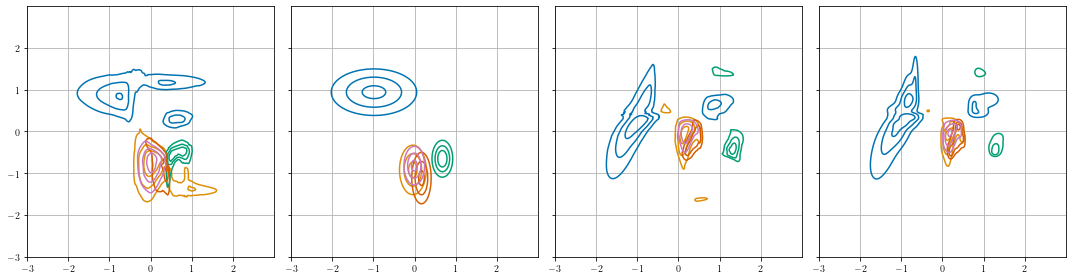

In [8]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15, 4))
axes = axes.flatten()

X_temp, M_temp = large_datamodule.train_data[20:25][:2]
X_temp, M_temp = torch.tensor(X_temp), torch.tensor(M_temp)

# Load model
version = '1697838'
checkpoint = 'epoch=499-step=151499'
mvae = VAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2_large/compare/vae_z25_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')

grid_min, grid_max = -3, 3
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# Compute marginal and joint
with torch.inference_mode():
    out = get_marginal_logprob_for_Zgrid(mvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                         compute_complete=True, return_joint=True, 
                                         marginal_eval_batchsize=1)

# Incomplete data
posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[0], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Incomplete variational
with torch.inference_mode():
    variational_logprob = compute_incomplete_variational_posterior_grid_logprob(mvae, X_temp, M_temp, Z)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[1], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

# Load model
version = '1757690'
checkpoint = 'epoch=499-step=151499'
mvae = VAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2_large/compare/multiple_vae_k25_z1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')

# Create grid
grid_min, grid_max = -3, 3
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# Compute marginal and joint
with torch.inference_mode():
    out = get_marginal_logprob_for_Zgrid(mvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                         compute_complete=True, return_joint=True, 
                                         marginal_eval_batchsize=1)

# Incomplete data
posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[2], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Complete variational
with torch.inference_mode():
    variational_logprob = compute_incomplete_variational_posterior_grid_logprob(mvae, X_temp, M_temp, Z)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[3], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)


fontsize=20

fig.tight_layout()


Sum: tensor(1.0000)
Sum: tensor(0.9964)
Sum: tensor(1.0000)
Sum: tensor(0.9994)


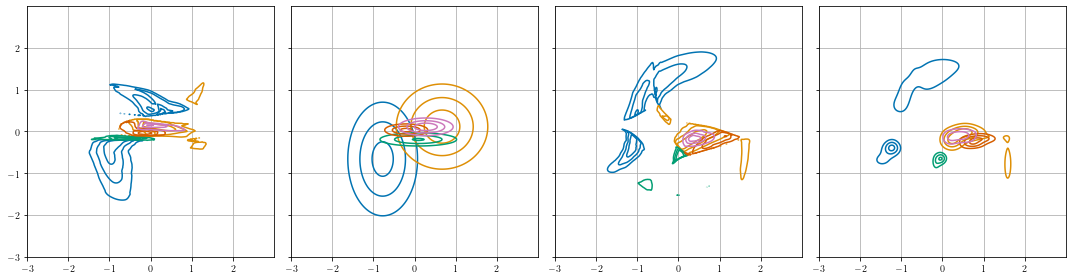

In [9]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15, 4))
axes = axes.flatten()

X_temp, M_temp = large_datamodule.train_data[20:25][:2]
X_temp, M_temp = torch.tensor(X_temp), torch.tensor(M_temp)

# Load model
version = '1697828'
checkpoint = 'epoch=499-step=151499'
mvae = IWAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2_large/compare/iwae_i25_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')
num_importance_samples = 25
num_indep_samples = 10000

# Create grid
grid_min, grid_max = -3, 3
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# Compute marginal and joint
with torch.inference_mode():
    out = get_marginal_logprob_for_Zgrid(mvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                         compute_complete=True, return_joint=True, 
                                         marginal_eval_batchsize=1)

# Incomplete data
posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[0], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

#Incomplete variational
with torch.inference_mode():
    variational_logprob = compute_incomplete_variational_posterior_grid_logprob(mvae, X_temp, M_temp, Z)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[1], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

# # Inomplete importance
# with torch.inference_mode():
#     variational_logprob = compute_iwae_posterior_grid_logprob_using_kde(mvae, X_temp, M_temp, Z,
#                                                                         num_importance_samples=num_importance_samples,
#                                                                         num_indep_samples=num_indep_samples)
# plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[1], colors=colors)
# print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)


# Load model
version = '1757050'
checkpoint = 'epoch=499-step=151499'
mvae = MultipleIWAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2_large/compare/multiple_iwae_k25_i1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')

# Create grid
grid_min, grid_max = -3, 3
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# Compute marginal and joint
with torch.inference_mode():
    out = get_marginal_logprob_for_Zgrid(mvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                         compute_complete=True, return_joint=True, 
                                         marginal_eval_batchsize=1)

# Incomplete data
posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[2], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Incomplete variational
with torch.inference_mode():
    variational_logprob = compute_incomplete_variational_posterior_grid_logprob(mvae, X_temp, M_temp, Z)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[3], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

# # Inomplete importance
# with torch.inference_mode():
#     variational_logprob = compute_iwae_posterior_grid_logprob_using_kde(mvae, X_temp, M_temp, Z,
#                                                                         num_importance_samples=num_importance_samples,
#                                                                         num_indep_samples=num_indep_samples)
# plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[3], colors=colors)
# print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

fontsize=20

fig.tight_layout()


Sum: tensor(1.0000)


100%|███████████████████████████████████████████████████████████| 5/5 [22:34<00:00, 270.96s/it]


Sum: tensor(0.9963, dtype=torch.float64)
Sum: tensor(1.0000)


100%|███████████████████████████████████████████████████████████| 5/5 [20:44<00:00, 248.85s/it]


Sum: tensor(0.9995, dtype=torch.float64)


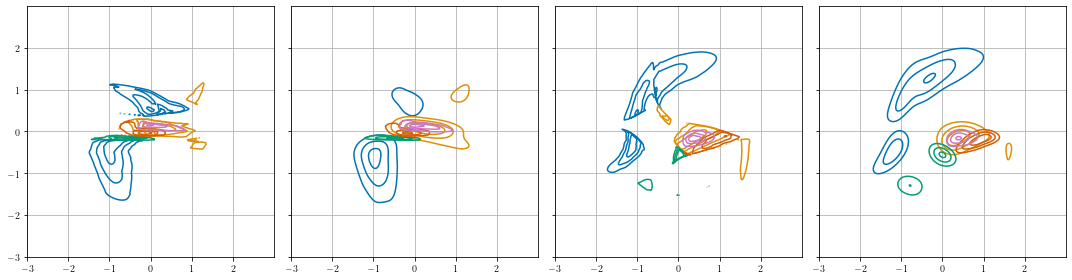

In [12]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15, 4))
axes = axes.flatten()

X_temp, M_temp = large_datamodule.train_data[20:25][:2]
X_temp, M_temp = torch.tensor(X_temp), torch.tensor(M_temp)

# Load model
version = '1697828'
checkpoint = 'epoch=499-step=151499'
mvae = IWAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2_large/compare/iwae_i25_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')
num_importance_samples = 25
num_indep_samples = 10000

# Create grid
grid_min, grid_max = -3, 3
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# Compute marginal and joint
with torch.inference_mode():
    out = get_marginal_logprob_for_Zgrid(mvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                         compute_complete=True, return_joint=True, 
                                         marginal_eval_batchsize=1)

# Incomplete data
posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[0], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# Incomplete variational
# with torch.inference_mode():
#     variational_logprob = compute_incomplete_variational_posterior_grid_logprob(mvae, X_temp, M_temp, Z)
# plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[1], colors=colors)
# print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

# Inomplete importance
with torch.inference_mode():
    variational_logprob = compute_iwae_posterior_grid_logprob_using_kde(mvae, X_temp, M_temp, Z,
                                                                        num_importance_samples=num_importance_samples,
                                                                        num_indep_samples=num_indep_samples)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[1], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)


# Load model
version = '1757050'
checkpoint = 'epoch=499-step=151499'
mvae = MultipleIWAEMargLogprob.load_from_checkpoint(f'../logs/toy_mog2_large/compare/multiple_iwae_k25_i1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{version}/checkpoints/{checkpoint}.ckpt')

# Create grid
grid_min, grid_max = -3, 3
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])

# Compute marginal and joint
with torch.inference_mode():
    out = get_marginal_logprob_for_Zgrid(mvae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                         compute_complete=True, return_joint=True, 
                                         marginal_eval_batchsize=1)

# Incomplete data
posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[2], colors=colors)
print('Sum:', posterior_logprob.exp()[:, 0].sum()*dz)

# # Incomplete variational
# with torch.inference_mode():
#     variational_logprob = compute_incomplete_variational_posterior_grid_logprob(mvae, X_temp, M_temp, Z)
# plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[3], colors=colors)
# print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

# Inomplete importance
with torch.inference_mode():
    variational_logprob = compute_iwae_posterior_grid_logprob_using_kde(mvae, X_temp, M_temp, Z,
                                                                        num_importance_samples=num_importance_samples,
                                                                        num_indep_samples=num_indep_samples)
plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[3], colors=colors)
print('Sum:', variational_logprob.exp()[:, 0].sum()*dz)

fontsize=20

fig.tight_layout()
